In [25]:
import pandas as pd
import numpy as np
from collections import Counter
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.metrics import BinaryAccuracy, AUC

import matplotlib.pyplot as plt
# https://nlpretext.readthedocs.io/en/latest/
from nlpretext import Preprocessor
from nlpretext.basic.preprocess import normalize_whitespace, remove_punct, remove_eol_characters, remove_stopwords, \
   lower_text, remove_accents, remove_multiple_spaces_and_strip_text, replace_numbers, replace_emails, replace_urls
from nlpretext.social.preprocess import convert_emoji_to_text, remove_mentions, extract_mentions, remove_hashtag, extract_hashtags

# some useful libraries
# spacy

np.random.seed(42)

In [26]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [27]:
print(train_data.shape)
print(train_data["text"][5])
print(train_data["target"][5])

(7613, 5)
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
1


In [28]:
# text pre-processing
counter = 0
def get_str_hashtags(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(extract_hashtags)
    lst = preprocessor.run(text)    
    str = ""
    for word in lst:
        str += " " + word.replace('#', '')
    return str

def get_str_mentions(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(extract_mentions)
    lst = preprocessor.run(text)
    str = ""
    for word in lst:
        str += " " + word.replace('@', '')
    return str
    

def clean_text(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(lower_text)
    preprocessor.pipe(remove_mentions)
    preprocessor.pipe(remove_hashtag)
    preprocessor.pipe(convert_emoji_to_text)
    preprocessor.pipe(remove_eol_characters)
    preprocessor.pipe(remove_stopwords, args={'lang': 'en'})
    preprocessor.pipe(remove_punct)
    preprocessor.pipe(replace_urls)
    preprocessor.pipe(replace_emails)
    preprocessor.pipe(replace_numbers)
    preprocessor.pipe(remove_accents)
    preprocessor.pipe(remove_multiple_spaces_and_strip_text)
    preprocessor.pipe(normalize_whitespace)
    
    text = preprocessor.run(text)

    return text

In [16]:
# clean train data and save it to a csv
train_data['clean_text'] = train_data.text.apply(lambda x: clean_text(x))
train_data['hashtags'] = train_data.text.apply(lambda x: get_str_hashtags(x))
train_data['mentions'] = train_data.text.apply(lambda x: get_str_mentions(x))
train_data.to_csv('train_clean.csv')


In [24]:
# clean test data and save it to a csv
test_data['clean_text'] = test_data.text.apply(lambda x: clean_text(x))
test_data['hashtags'] = test_data.text.apply(lambda x: get_str_hashtags(x))
test_data['mentions'] = test_data.text.apply(lambda x: get_str_mentions(x))
test_data.to_csv('test_clean.csv')

















 sunkxssedharry


 ablaze_co ablaze

 Etsy
 CyhiThePrynce


 CTVToronto

 John_Kass
 PhilippaEilhart DhuBlath





 Traffic_SouthE roadpol_east
 sakuma_en
 1800_Injured

 RobynJilllian WlSDOMTEETHS

 DaveOshry Soembie

 Calum5SOS


 bxckylynch

 djicemoon
 LACo_FD
 djicemoon



 djicemoon




 JadeForMKX


 rewind_music

 Mintechan


 god



 thugIauren
 yankees




 M__Belly brightasastar_

 disneyxrowbrina

 margaretcho

 vballplaya2296




 kdunning1919 hsnowberger gabrielasmith29
 ViralSpell
 ViralSpell
 RosieGray
 johnboywest
 _drodrolagi

 jacksfilms

 NinaHoag
 thehill



 AlbertBreer




 Change

 Change
 Change
 Change
 BosTeenAuthFest

 jackienatalydlt
 Change
 Change
 INCIndia
 Change
 Change
 Change
 Change
 Change
 Change
 Change
 spherulitic
 YouTube teamtwiistz
 YouTube
 thomasa56


 ItsKingRiffYall
 TMFK_CO


 5SOStag

 YouTube
 YouTube

 YouTube

 YouTube



 hitchBOT



 PCraigRoberts












 LouisvilleUSACE







 pnuts_mama


 an_opus





 Vix

In [4]:
df = pd.read_csv("./train_clean.csv")
print(df.shape)

(7613, 7)


The test data does not have a target column, so we cannot evaluate our models using the test data. We need to split the first dataset into a test and train dataset.

In [5]:
# split the data into train and test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(df, df['target']):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

print(df_train.shape)
print(df_test.shape)
print(df_train.target.value_counts()/len(df_train))
print(df_test.target.value_counts()/len(df_test))

(5329, 7)
(2284, 7)
0    0.570276
1    0.429724
Name: target, dtype: float64
0    0.57049
1    0.42951
Name: target, dtype: float64


In [6]:
# reset indexes
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [27]:
cleaned_train_text = list(df_train["clean_text"])
labels_train = list(df_train["target"])
cleaned_test_text = list(df_test["clean_text"])
labels_test = list(df_test["target"])

In [29]:
# After cleaning the text, some value are NaN. So, we need to replace these values with an empty string
train_nan_indexes = df_train[df_train["clean_text"].isna()].index
for i in train_nan_indexes:
    cleaned_train_text[i] = ""

test_nan_indexes = df_test[df_test["clean_text"].isna()].index
for i in test_nan_indexes:
    cleaned_test_text[i] = ""

In [30]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
vocab_size = 1000
# word level one-hot encoding
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(cleaned_train_text)
sequences = tokenizer.texts_to_sequences(cleaned_train_text)
one_hot_results = tokenizer.texts_to_matrix(cleaned_train_text, mode='binary')
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels_train)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 17982 unique tokens
Shape of data tensor: (5329, 100)
Shape of label tensor: (5329,)


In [ ]:
# model taken from notes
# inputs = keras.Input(shape=(None,))
# embed_layer = keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=300,
#         mask_zero=True
#     )(inputs)
# x = keras.layers.Bidirectional(keras.layers.LSTM(64))(embed_layer)
# x = keras.layers.Dense(64, activation='relu')(x)
# outputs = keras.layers.Dense(units=2, activation='softmax')(x)

# model5 = keras.Model(inputs, outputs)

# model5.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy")

# model5.fit(data, labels, validation_split=0.3, epochs=5, batch_size=64)

# to add the keywords as inputs : https://stackoverflow.com/questions/55233377/keras-sequential-model-with-multiple-inputs

In [52]:
# trying recurrent layer
model = keras.models.Sequential()
model.add(layers.Input(shape=(None,)))
model.add(layers.Embedding(input_dim=vocab_size, output_dim=300, mask_zero=True))
model.add(layers.Bidirectional(layers.SimpleRNN(32, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.SimpleRNN(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
history = model.fit(data, labels, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
59/59 [==============================] - 10s 113ms/step - loss: 0.5833 - accuracy: 0.6890 - val_loss: 0.5569 - val_accuracy: 0.7430
Epoch 2/5
59/59 [==============================] - 6s 107ms/step - loss: 0.3905 - accuracy: 0.8324 - val_loss: 0.5288 - val_accuracy: 0.7699
Epoch 3/5
59/59 [==============================] - 6s 110ms/step - loss: 0.2674 - accuracy: 0.8971 - val_loss: 0.6247 - val_accuracy: 0.7317
Epoch 4/5
59/59 [==============================] - 6s 105ms/step - loss: 0.1699 - accuracy: 0.9408 - val_loss: 0.6973 - val_accuracy: 0.7305
Epoch 5/5
59/59 [==============================] - 6s 110ms/step - loss: 0.1225 - accuracy: 0.9590 - val_loss: 0.7539 - val_accuracy: 0.7567


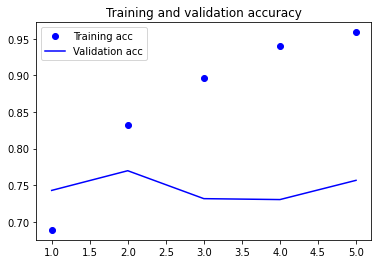

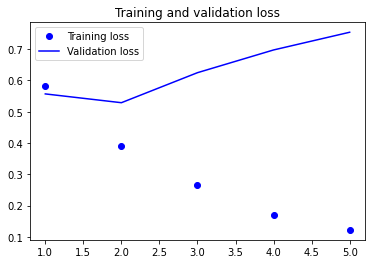

In [53]:
# plotting the model fit
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [63]:
# using LSTM layer
model2 = keras.models.Sequential()
model2.add(layers.Input(shape=(None,)))
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=300, mask_zero=True))
model2.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Bidirectional(layers.LSTM(32)))

model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy",AUC()])
history2 = model2.fit(data, labels, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
117/117 [==============================] - 39s 200ms/step - loss: 0.5451 - accuracy: 0.7381 - auc_15: 0.7867 - val_loss: 0.4895 - val_accuracy: 0.7867 - val_auc_15: 0.8257
Epoch 2/5
117/117 [==============================] - 18s 155ms/step - loss: 0.4113 - accuracy: 0.8279 - auc_15: 0.8800 - val_loss: 0.5058 - val_accuracy: 0.7624 - val_auc_15: 0.8315
Epoch 3/5
117/117 [==============================] - 17s 147ms/step - loss: 0.3756 - accuracy: 0.8437 - auc_15: 0.9008 - val_loss: 0.4964 - val_accuracy: 0.7855 - val_auc_15: 0.8416
Epoch 4/5
117/117 [==============================] - 17s 148ms/step - loss: 0.3469 - accuracy: 0.8536 - auc_15: 0.9160 - val_loss: 0.4987 - val_accuracy: 0.7674 - val_auc_15: 0.8373
Epoch 5/5
117/117 [==============================] - 18s 156ms/step - loss: 0.3195 - accuracy: 0.8660 - auc_15: 0.9295 - val_loss: 0.5241 - val_accuracy: 0.7792 - val_auc_15: 0.8392


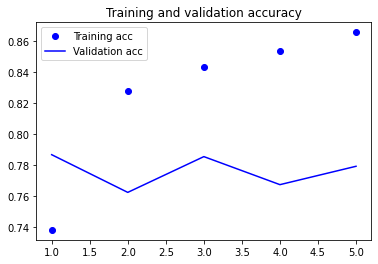

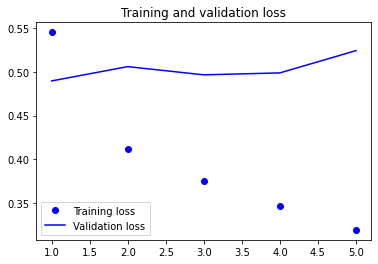

In [64]:
# plotting the model fit
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [56]:
# Tokenizing the test data split
# word level one-hot encoding
test_tokenizer = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer.fit_on_texts(cleaned_test_text)
test_sequences = test_tokenizer.texts_to_sequences(cleaned_test_text)
test_one_hot_results = test_tokenizer.texts_to_matrix(cleaned_test_text, mode='binary')
test_word_index = test_tokenizer.word_index
#print(f"Found {len(test_word_index)} unique tokens")

test_data = pad_sequences(test_sequences, maxlen=maxlen)

print('Shape of data tensor:', data.shape)

labels_test = np.asarray(labels_test)
print('Shape of data tensor:', test_data.shape)
print('Shape of label tensor:', labels_test.shape)


Shape of data tensor: (5329, 100)
Shape of data tensor: (2284, 100)
Shape of label tensor: (2284,)


In [65]:
# evaluate the model on the test data
test_evals = model.evaluate(test_data, labels_test)
print(test_evals)
# predict on the test data
predictions = model.predict(test_data)
predicted_lbls = np.argmax(predictions, axis=1)
cr = classification_report(labels_test, predicted_lbls)
print(cr)

72/72 [==============================] - 2s 23ms/step - loss: 1.4064 - accuracy: 0.5298
[1.4063867330551147, 0.5297723412513733]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1303
           1       0.00      0.00      0.00       981

    accuracy                           0.57      2284
   macro avg       0.29      0.50      0.36      2284
weighted avg       0.33      0.57      0.41      2284



C:\Users\DAVID\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DAVID\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DAVID\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [66]:
# evaluate the model on the test data
test_evals = model2.evaluate(test_data, labels_test)
print(test_evals)
# predict on the test data
predictions = model.predict(test_data)
predicted_lbls = np.argmax(predictions, axis=1)
cr = classification_report(labels_test, predicted_lbls)
print(cr)

72/72 [==============================] - 2s 33ms/step - loss: 1.1346 - accuracy: 0.5377 - auc_15: 0.5134
[1.134608268737793, 0.5376532673835754, 0.5133754014968872]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1303
           1       0.00      0.00      0.00       981

    accuracy                           0.57      2284
   macro avg       0.29      0.50      0.36      2284
weighted avg       0.33      0.57      0.41      2284



C:\Users\DAVID\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DAVID\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DAVID\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

The following is to create a submission for the Kaggle Competition

In [38]:
# create a submission using test data
test_data_clean = pd.read_csv("test_clean.csv")
cleaned_test_text = list(test_data_clean["clean_text"])
test_data_clean = test_data_clean.replace(test_data_clean[test_data_clean['clean_text'].isna()].index, '')
print(test_data_clean.shape)
cleaned_test_text = list(test_data_clean["clean_text"])
nanIndexes = test_data_clean[test_data_clean['clean_text'].isna()].index
for i in nanIndexes:
    cleaned_test_text[i] = ""
maxlen = 100
max_words = 10000
vocab_size = 1000
# word level one-hot encoding
test_tokenizer = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer.fit_on_texts(cleaned_test_text)
test_sequences = test_tokenizer.texts_to_sequences(cleaned_test_text)
test_one_hot_results = test_tokenizer.texts_to_matrix(cleaned_test_text, mode='binary')
test_word_index = test_tokenizer.word_index
#print(f"Found {len(test_word_index)} unique tokens")

test_data = pad_sequences(test_sequences, maxlen=maxlen)

print('Shape of data tensor:', data.shape)

predictions = model2.predict(test_data)
predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions))


res = []
for i in test_data_clean.index:
    res.append([test_data_clean["id"][i], predictions[i]])
predictions_df = pd.DataFrame(res, columns=["id", "target"])
predictions_df.to_csv("./model2predictions.csv", index=False)
